In [97]:
from ExploratoryFunctions import *

In [98]:
import seaborn as sns

In [99]:
import scipy.stats as stats

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
%matplotlib inline

In [102]:
data = pd.read_csv('merged_labeled_data.csv')
data.uids = data.uids.apply(eval)

In [103]:
data.columns

Index(['engagement', 'procedural', 'procedural_question', 'question',
       'weak_question', 'topic_intro', 'uids_str', 'Unnamed: 0',
       'committee_position', 'committee_position_next',
       'committee_position_prev', 'pid', 'pid_next', 'pid_prev',
       'simple_label', 'simple_label_next', 'simple_label_prev', 'text',
       'text_next', 'text_prev', 'uid_next', 'uid_prev', 'uids', 'vid'],
      dtype='object')

### Defining my classes
After looking over all of the utterances I realized I wanted to simplifiy my labels to two cases. 
1. The utterance implies the legislator is engaging with a witness or the bill author in a way that adds to the discussion.
    * engagement
    * question
2. The utterance is just part of legislative procedure. 
    * procedural
    * procedural_question

I'll combine these into my two classes.

In [104]:
data['label'] = data.apply(lambda row: get_classes(row), axis=1)

Okay let's checkout the break down of the classes

In [105]:
data.label.value_counts()

engagement     134
procedural      95
topic_intro      1
Name: label, dtype: int64

In [106]:
# A nested dictionary containing lists of all the features columns names in the "data" dataframe
features_dict = {}

### Examining Context
I already filtered to include only utterances that I thought would be likely to indicate engagement. However, logically the committee position and category of the speaker as well as those preceding and suceeding the speaker might still be important in determining the label.

In [107]:
context_features

['committee_position_prev',
 'committee_position',
 'committee_position_next',
 'simple_label_prev',
 'simple_label',
 'simple_label_next']

I'll use a Chi-Square test to examine how well these variables define differences between my classes

In [108]:
scores = {}
for feat in context_features:
    # Creates my contigency table
    counts = pd.crosstab(data[feat], data.label)
    X_sq, p_val, df, expected = stats.chi2_contingency(observed= counts)
    scores[feat] = X_sq
    print('Feature:', feat, '\n')
    print('Value Counts:\n', data[feat].value_counts(), '\n')
    print('Test Stat:', X_sq, 'P-Val:', p_val, '\n')
    print('=========================================')

Feature: committee_position_prev 

Value Counts:
 Not In Committee    80
Member              77
Chair               57
Possible Chair       8
Vice-Chair           7
Co-Chair             1
Name: committee_position_prev, dtype: int64 

Test Stat: 57.5584575929 P-Val: 1.04675819112e-08 

Feature: committee_position 

Value Counts:
 Member                 159
Not In Committee        37
Vice-Chair              18
Possible Chair          15
Possible Vice-Chair      1
Name: committee_position, dtype: int64 

Test Stat: 17.07163726 P-Val: 0.0293717112817 

Feature: committee_position_next 

Value Counts:
 Not In Committee    199
Member               30
Chair                 1
Name: committee_position_next, dtype: int64 

Test Stat: 12.3388430763 P-Val: 0.0150016277831 

Feature: simple_label_prev 

Value Counts:
 Legislator          161
General Public       33
Bill Author          16
State Agency Rep     11
LAO                   4
Unlabeled             3
Lobbyist              2
Name: simple_la

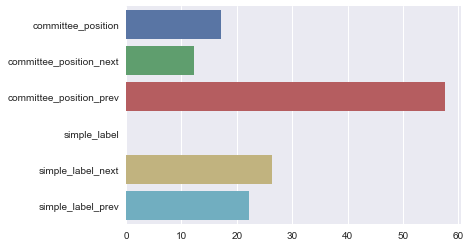

In [109]:
scores = pd.Series(scores)
ax = sns.barplot(x=scores.values, y=scores.keys())

Most features have really high test statistics indicating that they are not independent of my classes. "simple_label" is obviously 0 because it is always legislator. 

In [110]:
# Hot encoding for 'context' features
d = {}
features_dict['context_features'] = d
for feat in context_features:
    dummies = pd.get_dummies(data[feat])
    dummies.columns = [feat + '_' + col for col in dummies]
    
    d[feat] = list(dummies.columns)
    data = pd.concat([data, dummies], axis=1)
    

### Engineered Features
Before moving on to text based features, I want to create a couple of features based around the length of the interaction to help separate the classes. Typically engagement interactions are longer than procedural ones, so it seems reasonable that this might help.  

In [111]:
data['word_count'] = data.text.apply(lambda t: len(word_tokenize(t)))
data['prev_word_count'] = data.text_prev.apply(lambda t: len(word_tokenize(t)))
data['next_word_count'] = data.text_next.apply(lambda t: len(word_tokenize(t)))

data['uid_count'] = data.uids.apply(len)
data['?_count'] = data.text.apply(lambda t: t.count('?'))
# Ratio of question marks to total words
data['?_ratio'] = data['?_count'] / data.word_count

In [112]:
eng_features

['word_count',
 'prev_word_count',
 'next_word_count',
 'uid_count',
 '?_count',
 '?_ratio']

In [113]:
scores = {}
for feat in eng_features:
    a = data.loc[data.label == 'engagement', feat]
    b = data.loc[data.label == 'procedural', feat]
    
    t, p_val = stats.ttest_ind(a, b, equal_var=False)
    scores[feat] = t
    
    print('Feature:', feat, '\n')
    print('Test Stat:', t, 'P-Val:', p_val, '\n')
    print('=========================================')

Feature: word_count 

Test Stat: 5.50318019645 P-Val: 1.56771236264e-07 

Feature: prev_word_count 

Test Stat: -0.575952341431 P-Val: 0.565303459093 

Feature: next_word_count 

Test Stat: 1.48340115549 P-Val: 0.139505857597 

Feature: uid_count 

Test Stat: 2.152242483 P-Val: 0.0324779266918 

Feature: ?_count 

Test Stat: 5.4978710857 P-Val: 1.0324216843e-07 

Feature: ?_ratio 

Test Stat: -1.14023613865 P-Val: 0.256522084888 



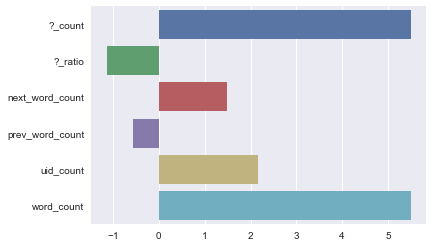

In [114]:
scores = pd.Series(scores)
ax = sns.barplot(x=scores.values, y=scores.keys())

Hmm, I definitely want to retain word count and "?" count in the final model and I'll probably ignore the others. 

In [115]:
features_dict['eng_features'] = eng_features

### Text Features

I want to create text based features for my model. This involves looking at specific words as well as generating tf-idf scores for words a n-grams. 


In [116]:
# objects needed for text processing
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
translator = str.maketrans(dict.fromkeys(string.punctuation))

In [117]:
# creates processed versions of the three texts
text_features = ['text', 'text_next', 'text_prev']

processed_text_features = []
for feat in text_features:
    feat = 'processed_' + feat
    data[feat] = data.text.apply(process_text, 
                                 stemmer=stemmer, 
                                 translator=translator, 
                                 stop_words=stop_words)

Basically all question words are stop-words, so I thought it might be useful to have a separate way to compute these. I want to single these out in particular because they often times signal engagement.

In [118]:
# from wikipedia
interrogative_words

{'how',
 'what',
 'when',
 'whence',
 'where',
 'whether',
 'which',
 'whither',
 'who',
 'whom',
 'whose',
 'why'}

In [119]:
for feat in text_features:
    feat = 'q_' + feat
    data[feat] = data.text.apply(only_q_words, interrogative_words=interrogative_words)
    

**Note:** I ended up not using these because instead of filtering out stopwords directly I just set a maximum document frequency. However I left this piece in in case a future user might want to go this route

In [120]:
# Not totally sure why, but some classifiers need this
data['binary_label'] = [0 if lab == 'procedural' else 1 for lab in data.label]

In [121]:
pickle.dump(data, open('processed_data.pkl', 'wb'))

pickle.dump(features_dict, open('features_dict.pkl', 'wb'))